<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/LLMpro_hw2_NosenkoArtem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 2

В этом задании вам предстоит реализовать контрастивное обучние эмбеддера, посмотреть на его влияние на задаче классификации и отбора кандидатов.

Языковое моделирование рассматривать не будем в силу дороговизны подхода.

## Часть 1. Triplet loss на стероидах

Вам поставили задачу: на фиксированном множестве точек произвести классификацию, при этом множество таково, что качество на исходных данных неприемлемо. Что делать? Последуем совету из лекции и реализуем контрастивное обучение.

В этом и последующем задании вам предстоит реализовать дообучение некоторого простого эмбеддера на домен.

Эмбеддинги заморожены -- будем дообучать только полносвязную голову.

In [ ]:
from dataclasses import dataclass

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

In [ ]:
SEED = 42

@dataclass
class DatasetConfig:
    n_samples: int = 5000
    n_features: int = 32
    n_classes: int = 8
    n_clusters_per_class: int = 2
    n_informative: int = 5
    random_state: int = SEED

@dataclass
class SplitConfig:
    random_state: int = SEED
    test_size: float = 0.25

@dataclass
class TSNEConfig:
    n_components: int = 2
    random_state: int = SEED
    perplexity:   int = 30

In [ ]:
X, y = make_classification(**DatasetConfig().__dict__)

X_train, X_test, y_train, y_test = train_test_split(X, y, **SplitConfig().__dict__)
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()

## 1.Визуализация данных - 1 баллов

Напишите функцию `plot_tsne(data, labels, **kwargs)`, принимающую на вход матрицу эмбеддингов и метки классификации и строящую t-SNE-разложение на плоскости. Изобразите его, раскрасив классы по цветам. Зафиксируйте `random_state` при построении.

Цель задания: получить визуальное представление о природе распределения в данных. Для доменной адаптации визуализация - важный инструмент интерпретации результата.

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Ваш код здесь ----
def plot_tsne(data, labels, plot_title):
    transformed_data = TSNE(**TSNEConfig().__dict__).fit_transform(data)

    red = labels == 0
    green = labels == 1
    fig = plt.figure(figsize=(15, 8))
    plt.scatter(data[red, 0], data[red, 1], c="r")
    plt.scatter(data[green, 0], data[green, 1], c="g")
    plt.title(plot_title)
# ---- Конец кода ----


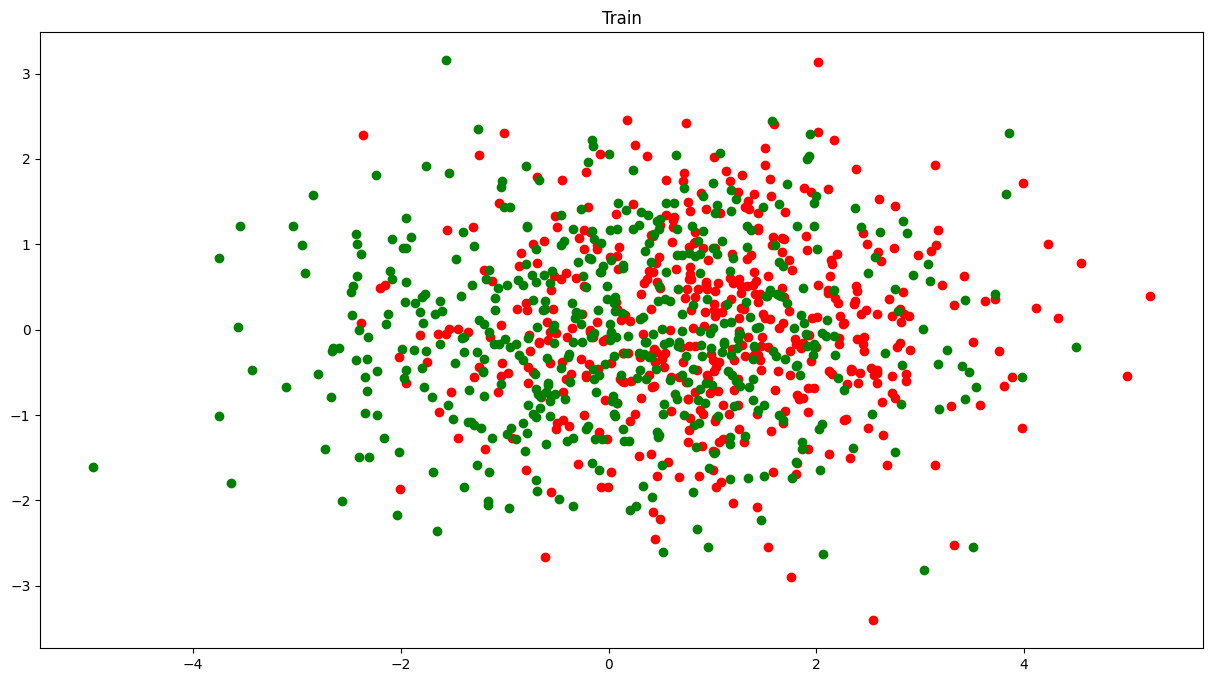

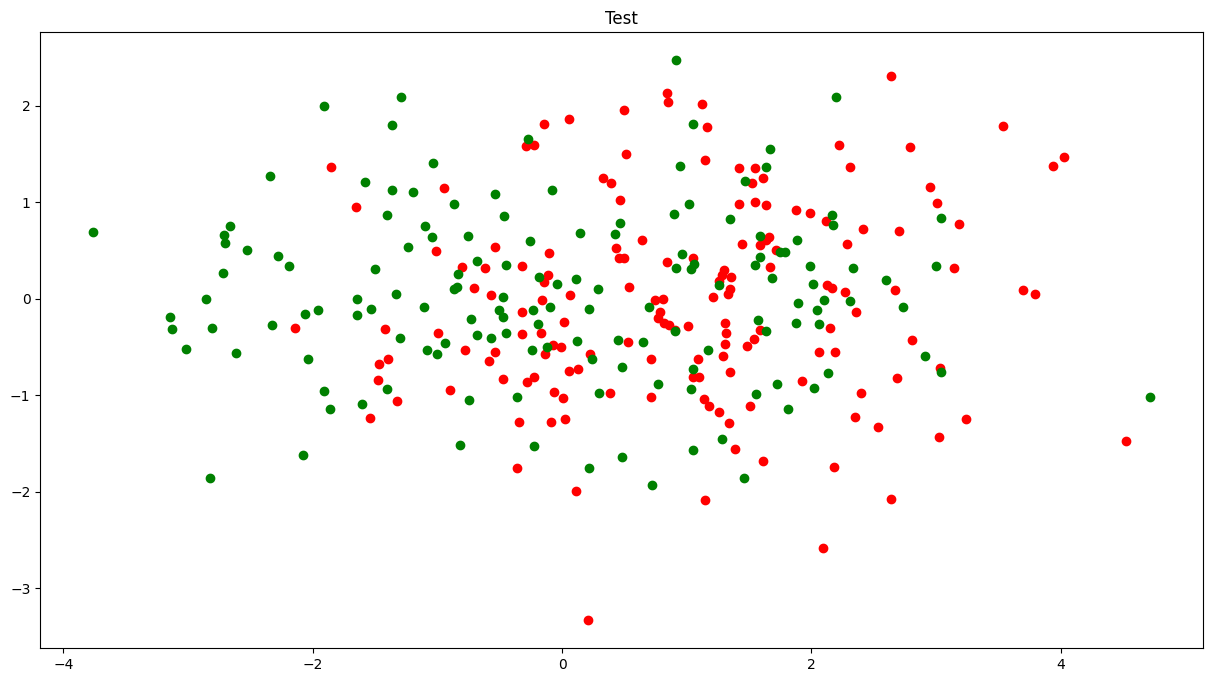

In [ ]:
plot_tsne(X_train, y_train, 'Train')
plot_tsne(X_test, y_test, 'Test')

## 2.Базовый классификатор

Выберем алгоритм классификации kNN и метрику качества Accuracy. Оценим базовое качество на тестовых данных.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)

print(score)

0.5144


## 3.TripletLoss - 5 баллов

Давайте разберёмся, что такое Triplet Loss и как мы будем его использовать в несколько изменённом виде.

### Идея Triplet Loss

Цель обучения на Triplet Loss — научить модель отличать похожие объекты от непохожих. Для этого мы работаем с "триплетами" (тройками) векторов:

1.  **Якорь (`anchor`)**: Вектор нашего основного объекта $x$.
2.  **Позитив (`positive`)**: Вектор объекта $x^+$, который относится к тому же классу, что и якорь.
3.  **Негатив (`negative`)**: Вектор объекта $x^-$ из другого класса.

Цель — сделать так, чтобы в пространстве векторов "якорь" был ближе к "позитиву", чем к "негативу", причём с некоторым запасом (`margin`).

Функция ошибки Triplet Loss для одного триплета выглядит так:

$$\max\left(0,\|f(x)-f(x^+)\|^2_2-\|f(x)-f(x^-)\|^2_2+\varepsilon\right)$$

Заметим, что в случае L2-нормилизованных векторов:

$$\max\left(0,\|f(x)-f(x^+)\|^2_2-\|f(x)-f(x^-)\|^2_2+\varepsilon\right)=\max\left(0,f(x)f^T(x^-)-f(x)f^T(x^+)+\hat{\varepsilon}\right)$$

Пусть $D=\{x_i, y_i\}_i$ -- выборка классификации. Позитивные пары в $D$ формируются такими $(i,j)$, что $i \neq j$ и $y_i = y_j$, негативные - $i \neq j$ и $y_i \neq y_j$. Пусть $S=XX^T - \text{diag}(XX^T)$, где $\text{diag}(А)$ - преобразование квадратной матрицы $A$ к диагональной, в которой элементы на диагонали совпадают с диагональю $A$. То есть в $S$ диагональ занулена. По матрице $S$ можно сформировать два непересекающихся множества: позитивов $P$ и негативов $N$. Пусть $L$ -- минимальное количество элементов в каждом из двух множеств. Возьмем $\hat{P}=\{p_i\}_i$, $\hat{N}=\{n_i\}_i$ как сэмплы без возвращения размера $L$ из $P$ и $N$ соответственно. Тогда итоговая функция ошибки выглядит так:

$$\mathcal{L}=\frac{1}{L}\sum\limits_{i=1}^L\max\left(0, n_i-p_i+\hat{\varepsilon}\right)$$

В чем модификация? В том, что в паре позитивов и негативов не обязательно должен быть один и тот же якорный элемент. И это работает.

Реализуйте callable-класс `TripletLoss` по описанию.

Примечание: для прохождения тестов используйте сэмплирование через `np.random.default_rng(self.random_state).choice`.

In [ ]:
# ---- Ваш код здесь ----
class TripletLoss():

    def __init__(self, margin, random_state=None):
        self.margin = margin
        self.random_state = random_state

    def __call__(self, x, labels):

# ---- Конец кода ----


In [ ]:
# ---- Ваш код здесь ----
class TripletLoss():

    def __init__(self, margin, random_state=None):
        self.margin = margin
        self.random_state = random_state

    def __call__(self, x: torch.Tensor, labels: torch.Tensor):
        x = F.normalize(x, p=2, dim=1).to(device)
        XX_T = x @ x.T - torch.diag(x @ x.T)
        positive_mask = self._get_positives(labels)
        negative_mask = self._get_negatives(labels)
        n_samples = torch.min(positive_mask.sum(), negative_mask.sum())

        # считаем расстояния до позитивов и негативов
        dist_positive = XX_T[positive_mask]
        dist_negatives = XX_T[negative_mask]

        #семплируем позитивы и негативы
        positive_indices = np.random.default_rng(self.random_state).choice(len(dist_positive), size=n_samples.item(), replace=False)
        negative_indices = np.random.default_rng(self.random_state).choice(len(dist_negatives), size=n_samples.item(), replace=False)

        positive_samples = dist_positive[positive_indices]
        negative_samples = dist_negatives[negative_indices]

        losses = torch.clamp(negative_samples - positive_samples + self.margin, min=0)

        return losses.mean()

    @staticmethod
    def _get_positives(labels: torch.Tensor):
        labels_size = len(labels)
        eq_labels = (labels.view(1, labels_size) == labels.view(labels_size, 1)).to(device)
        # убираем диагональ :)
        eyes = torch.eye(labels_size, dtype=torch.bool, device=device)
        return eq_labels & ~eyes

    @staticmethod
    def _get_negatives(labels: torch.Tensor):
        labels_size = len(labels)
        eq_labels = (labels.view(1, labels_size) == labels.view(labels_size, 1)).to(device)
        # убираем диагональ :)
        eyes = torch.eye(labels_size, dtype=torch.bool, device=device)
        return ~eq_labels & ~eyes

# ---- Конец кода ----


In [ ]:
criterion = TripletLoss(0.2, random_state=101)


objects = torch.tensor(
    [[-1.7651, -1.5979,  0.1042,  0.3825, -0.9419, -0.2580, -0.6087, -0.1711,
        1.3922,  0.8548, -0.9251,  0.6989,  0.4238, -0.1330,  0.2985],
    [ 1.6144,  0.0627,  0.3424, -0.8591,  0.1869, -0.8598, -0.7200,  0.9449,
        -0.1684,  1.0282, -1.2377, -1.2640,  0.7469,  1.9605, -0.1214],
    [ 1.1143, -0.6948,  0.3739, -1.1461,  0.6456, -0.3360, -0.8111, -0.8861,
        0.7176, -0.6235, -0.9364,  0.6174,  2.7212, -2.0703, -2.2571],
    [ 0.7525,  2.1028,  2.7782,  0.5040, -1.5791,  1.5342,  0.0816,  0.3245,
        -0.0857, -0.5992, -1.4339,  0.0897, -1.5096,  0.1428, -0.1488],
    [-0.7518,  0.2623, -0.4958, -1.6063,  0.2537, -0.1137,  0.3985,  1.0155,
        0.1874, -0.4300, -1.2309,  1.5760, -1.3176,  1.5355,  1.8471],
    [ 1.9290, -0.3236,  0.4303,  0.7111,  1.4234,  1.7901,  0.2216, -1.5471,
        0.9389, -0.3012, -1.6487,  1.5765, -1.1450,  0.3260,  0.4909],
    [ 0.7837, -0.8004, -0.0929, -1.2220,  2.2333,  0.3288, -0.5222, -0.7202,
        0.6147,  1.8012, -0.2388, -0.2539,  0.0191, -0.0104,  0.5717],
    [-0.2709, -1.7985, -0.3959, -1.1190,  0.8644,  0.3008, -1.0336, -0.1251,
        -0.3357,  0.7938,  3.2090, -0.4332, -0.0496, -0.2672,  0.9690],
    [-0.1109,  0.4130,  0.7406, -1.2446, -0.4252,  2.5128, -0.2765,  0.6845,
        1.1965,  1.4173, -1.4604,  0.2515,  0.6387, -1.8519,  1.1899],
    [-0.1781, -0.7473, -0.1015,  0.2280, -1.5815,  0.1535, -1.3912, -2.2026,
        1.0496,  0.3547,  0.8897, -0.6482,  0.0133,  1.0124, -0.4452]])

labels = torch.LongTensor([1, 1, 2, 2, 3, 3, 4, 4, 5, 5])
assert abs(criterion(objects, labels).item() - 0.29527) < 1e-4

## 4.Модель и функция обучения - 8 балла

Реализуйте функцию `domain_adaptation(X_train, y_train, hidden_dim, out_dim, margin, N_epoch, batches_per_epoch, batch_size) -> MLP`, базовый цикл batch-обучения линейной головы, полносвязной нейронной сети. Батч для обучения можно либо сэмплировать произвольно из всего обучающего множества через `random.choice`, либо заранее сделать случайную перестановку датасета, как итог пройти `batches_per_epoch` батчей из датасета за одну эпоху.

Используйте реализацию полносвязной нейронной сети через класс `MLP`.

Требуется выбить на тесте 0.60 точности.

Цель задания - закрепить использование `TripletLoss` на простых модельных данных.

In [ ]:
from tqdm import tqdm_notebook as tqdm

import random

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, drop_prob=0.3):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

        self.bn = nn.BatchNorm1d(hidden_dim)
        self.drop = nn.Dropout(drop_prob)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.drop(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [ ]:
input_dim = X_train.shape[-1]
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

triplet_loss = TripletLoss(margin=0.3, random_state=SEED)
model = MLP(input_dim=input_dim, hidden_dim=256, out_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'Устройство :{device}')
print(f'Входная размерность :{input_dim}')

Устройство :cuda
Входная размерность :32


In [ ]:
# ---- Ваш код здесь ----
def domain_adaptation(
        X_train, y_train,
        # hidden_dim=128,
        # out_dim=64,
        # margin=0.2,
        model,
        N_epoch=80,
        batches_per_epoch=750,
        batch_size=256,
        random_state=SEED,
        device=device
        ):
  n_samples, input_dim = X_train.shape

  if random_state is not None:
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)

  if not isinstance(X_train, torch.Tensor):
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
  if not isinstance(y_train, torch.Tensor):
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

  X_train = X_train.to(device)
  y_train = y_train.to(device)

  # X_test.to(device)
  # y_test.to(device)

  model = model.to(device)

  losses_history = []
  for epoch in tqdm(range(N_epoch)):
    epoch_losses = []
    indices = torch.randperm(n_samples, device=device)

    start_idx, end_idx = 0, batch_size
    for batch_idx in range(batches_per_epoch):
      # start_idx = (batch_idx * batch_size) % n_samples
      # end_idx = min(start_idx + batch_size, n_samples)

      if end_idx >= n_samples:
        indices = torch.randperm(n_samples, device=device)
        start_idx, end_idx = 0, batch_size

      batch_indices = indices[start_idx:end_idx]

      # Формируем батч
      X_batch = X_train[batch_indices]
      y_batch = y_train[batch_indices]

      embeddings = model(X_batch)
      loss = triplet_loss(embeddings, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())

      start_idx += batch_size
      end_idx += batch_size

    avg_loss = np.mean(epoch_losses)
    losses_history.append(avg_loss)

    # model.eval()
    # with torch.no_grad():
    #   embeddings = model(X_test)
    #   loss_val = triplet_loss(embeddings, y_test)


    if (epoch + 1) % 10 == 0 or epoch == 0:
      # print(f"Эпоха [{epoch+1:3d}/{N_epoch}], Loss_train: {avg_loss:.4f}, Loss_val: {loss_val}")
      print(f"Эпоха [{epoch+1:3d}/{N_epoch}], Loss_train: {avg_loss:.4f}")

  print(f"Обучение завершено. Финальный loss: {losses_history[-1]:.4f}")
  return model, losses_history

# ---- Конец кода ----


NameError: name 'device' is not defined

In [ ]:
model, loss = domain_adaptation(X_train, y_train, model)

/tmp/ipython-input-120553806.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(N_epoch)):


  0%|          | 0/80 [00:00<?, ?it/s]

Эпоха [  1/80], Loss_train: 0.2561
Эпоха [ 10/80], Loss_train: 0.2230
Эпоха [ 20/80], Loss_train: 0.2171
Эпоха [ 30/80], Loss_train: 0.2137
Эпоха [ 40/80], Loss_train: 0.2110
Эпоха [ 50/80], Loss_train: 0.2079
Эпоха [ 60/80], Loss_train: 0.2054
Эпоха [ 70/80], Loss_train: 0.2026
Эпоха [ 80/80], Loss_train: 0.2002
Обучение завершено. Финальный loss: 0.2002


## 5.Итоговое качество - 1 балл

Отобразите новое распределение t-SNE-координат и посчитайте тестовую метрику. Сделайте краткий вывод.

Что тут важно: перед тем, как применить kNN-классификатор, который несколько строчек кода назад был нашим baseline-решением, нужно применить над исходными данными преобразование обученной моделью представлений, фактически выходом функции `domain_adaptation`.

Цель задания: изучить, как поменялось распределение в данных после доменной адаптации.

In [ ]:
model.eval()
with torch.no_grad():
  X_train_emb = model(torch.FloatTensor(X_train).to(device))
  X_test_emb = model(torch.FloatTensor(X_test).to(device))

X_train_emb = X_train_emb.to('cpu')
X_test_emb = X_test_emb.to('cpu')

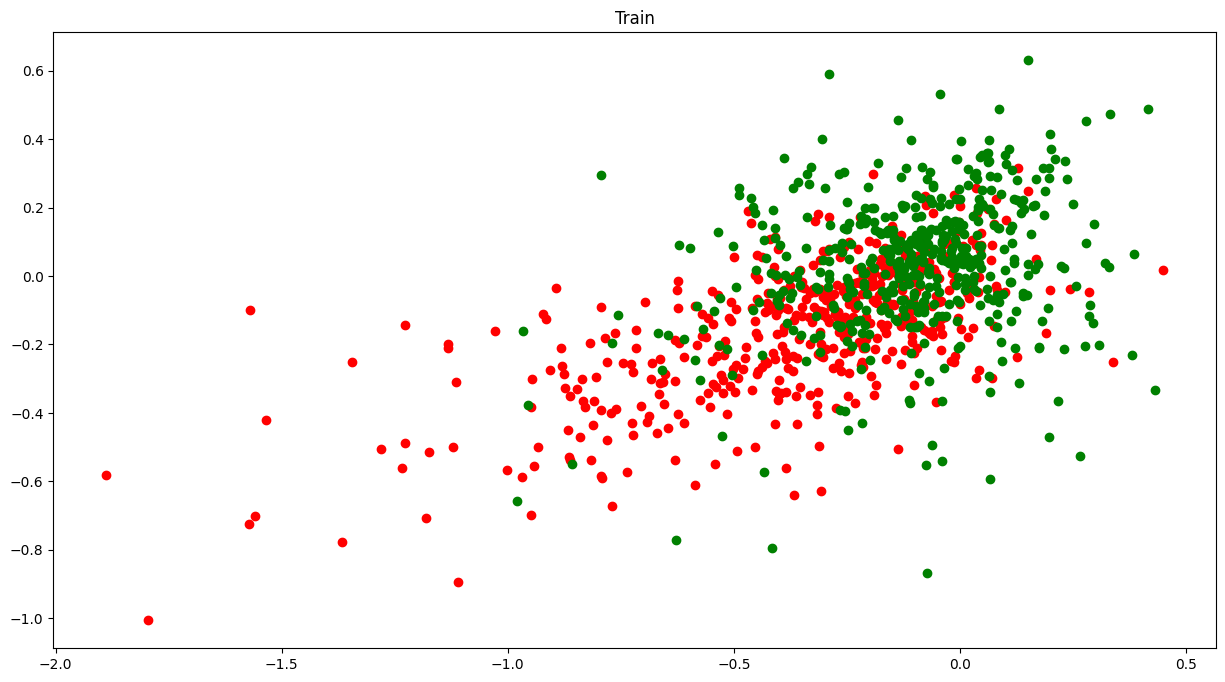

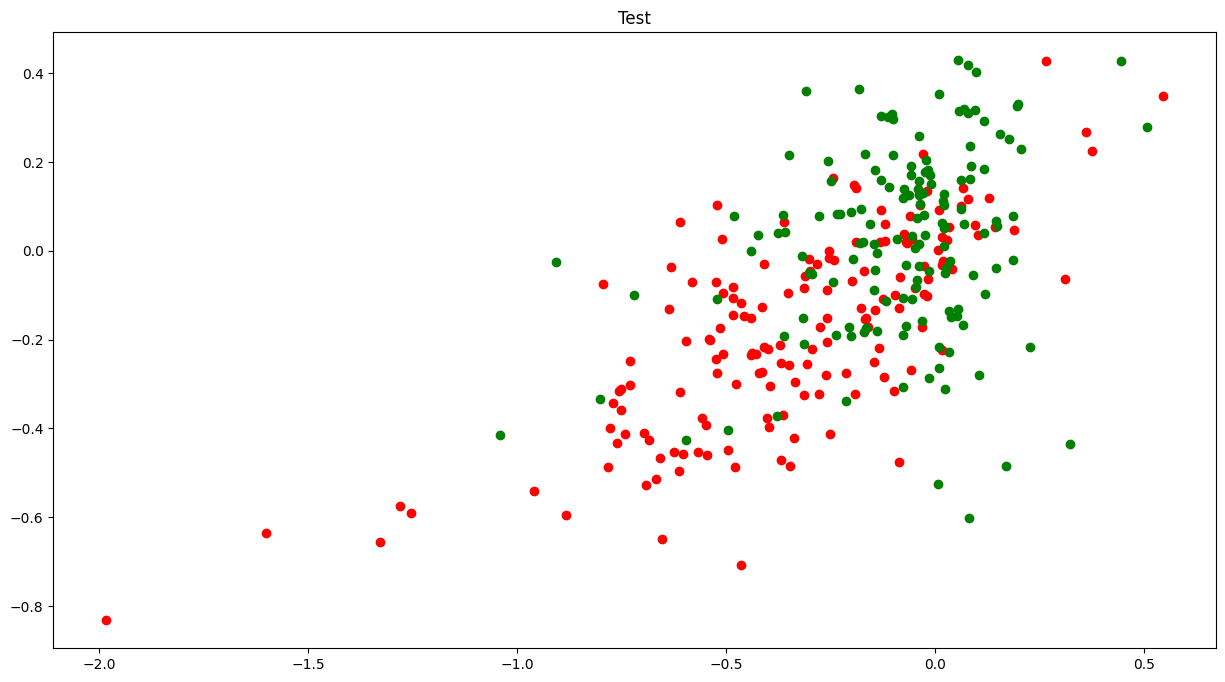

In [ ]:
plot_tsne(X_train_emb, y_train, 'Train')
plot_tsne(X_test_emb, y_test, 'Test')

In [ ]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_emb, y_train)

y_pred = clf.predict(X_test_emb)
score = accuracy_score(y_test, y_pred)

print(score)


0.6056


In [ ]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_emb, y_train)

y_pred = clf.predict(X_test_emb)
score = accuracy_score(y_test, y_pred)

print(score)

0.6176


## Часть 2. Triplet loss на чем-то посерьезнее

Рассмотрим теперь более живую задачу классификации. Будем работать с новостными группами.

Постановка та же, только возьмем теперь предобученный эмбеддер с HF. Эмбеддинги заморожены -- будем дообучать только полносвязную голову.

Поменяем так же алгоритм классификации с kNN на LogReg (по большей части для разнообразия).

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer

In [ ]:
categories = [
    "sci.space",
    "sci.med",
    "sci.electronics",
    "comp.os.ms-windows.misc",
    "comp.sys.ibm.pc.hardware",
    "comp.sys.mac.hardware"
]

newsgroups_train = fetch_20newsgroups(subset="train", categories=categories)
newsgroups_test = fetch_20newsgroups(subset="test", categories=categories)

X_train = newsgroups_train.data
X_test = newsgroups_test.data

y_train = newsgroups_train.target
y_test = newsgroups_test.target

In [ ]:
def test_logreg(X_train_mapped, y_train, X_test_mapped, y_test, target_names=newsgroups_test.target_names):
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train_mapped, y_train)

    y_pred = clf.predict(X_test_mapped)
    score = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names)

    print(f"Accuracy: {score:.3f}")
    print(f"Classification Report: {report}")

## 1.Выбираем англоязычный эмбеддер и формируем эмбеддинги - 1 балл

Выберите небольшой англоязычный sentence-трансформер, обученный на семантику, и прогоните через нее тексты обучения и тестирования.

Замерьте базовое качество классификатора на этих эмбеддингах.

Опционально: крайне рекомендую прогнать `plot_tsne` из прошлой части на тесте в тех же целях, что и в прошлых заданиях.

Цель задания: применить навыки выбора модели на основе описания ее области применения.

In [ ]:
model_name = 'all-MiniLM-L6-v2'

In [ ]:
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer

# ---- Ваш код здесь ----
print("Определяем модель, получаем эмбеддинги, визуализируем тест через t-SNE")
# ---- Конец кода ----
model = SentenceTransformer(model_name)
train_embeddings = model.encode(X_train, show_progress_bar=True, convert_to_numpy=True)
test_embeddings = model.encode(X_test, show_progress_bar=True, convert_to_numpy=True)

print(f"Размерность эмбеддинга: {train_embeddings.shape[1]}")

Определяем модель, получаем эмбеддинги, визуализируем тест через t-SNE


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Размерность эмбеддинга: 384


In [ ]:
test_logreg(train_embeddings, y_train, test_embeddings, y_test)

Accuracy: 0.827
Classification Report:                           precision    recall  f1-score   support

 comp.os.ms-windows.misc       0.82      0.84      0.83       394
comp.sys.ibm.pc.hardware       0.74      0.69      0.72       392
   comp.sys.mac.hardware       0.78      0.78      0.78       385
         sci.electronics       0.76      0.76      0.76       393
                 sci.med       0.94      0.95      0.94       396
               sci.space       0.92      0.93      0.93       394

                accuracy                           0.83      2354
               macro avg       0.83      0.83      0.83      2354
            weighted avg       0.83      0.83      0.83      2354



## 2.Обучаем эмбеддинги под задачу - 1 балл

Теперь точно придется обратиться к Части 1. Необходимо взять `domain adaptation` и обучить эмбеддиги на домен. Выходом будет линейная голова, как и в прошлой части, которую мы применим как преобразование исходных данных для улучшения представления и более качественного решения конечной задачи, в данном случае классификации.

In [ ]:
# ---- Ваш код здесь ----
def domain_adaptation(
        train_loader,
        model,
        N_epoch=80,
        batches_per_epoch=750,
        batch_size=256,
        random_state=SEED,
        device=device
        ):
  n_samples = len(X_train)

  if random_state is not None:
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    random.seed(random_state)

  model = model.to(device)

  losses_history = []
  for epoch in tqdm(range(N_epoch)):
    epoch_losses = []
    data_iterator = iter(train_loader)

    for batch_idx in range(batches_per_epoch):
      try:
        X_batch, y_batch = next(data_iterator)
      except StopIteration:
        data_iterator = iter(train_loader)
        X_batch, y_batch = next(data_iterator)
      if isinstance(X_batch, torch.Tensor):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

      embeddings = model(X_batch)
      loss = triplet_loss(embeddings, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_losses.append(loss.item())

    avg_loss = np.mean(epoch_losses)
    losses_history.append(avg_loss)


    if (epoch + 1) % 10 == 0 or epoch == 0:
      # print(f"Эпоха [{epoch+1:3d}/{N_epoch}], Loss_train: {avg_loss:.4f}, Loss_val: {loss_val}")
      print(f"Эпоха [{epoch+1:3d}/{N_epoch}], Loss_train: {avg_loss:.4f}")

  print(f"Обучение завершено. Финальный loss: {losses_history[-1]:.4f}")
  return model, losses_history

# ---- Конец кода ----


In [ ]:
class NewsgroupsDataset(Dataset):
    """Кастомный Dataset для 20 Newsgroups."""
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]


train_dataset = NewsgroupsDataset(
    texts=X_train,
    labels=y_train
)

test_dataset = NewsgroupsDataset(
    texts=X_test,
    labels=y_test
)

# Создание DataLoader для батчевой обработки
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, drop_prob=0.4):
        super().__init__()
        self.backbone = SentenceTransformer(model_name)
        for params in self.backbone.parameters():
          params.requires_grad = False

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

        self.bn = nn.BatchNorm1d(hidden_dim)
        self.drop = nn.Dropout(drop_prob)
        self.act = nn.GELU()

    def forward(self, x):
        with torch.no_grad():
          x = self.backbone.encode(x, convert_to_tensor=True)

        x = self.drop(x)
        x = self.fc1(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [ ]:
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

triplet_loss = TripletLoss(margin=0.2, random_state=SEED)
model = MLP(input_dim=384, hidden_dim=384*4, out_dim=384*2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'Устройство :{device}')

Устройство :cuda


In [ ]:
model, losses_history = domain_adaptation(
                                          train_loader,
                                          model,
                                          N_epoch=20,
                                          batches_per_epoch=750,
                                          random_state=SEED,
                                          device=device)

/tmp/ipython-input-1403155698.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(N_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

Эпоха [  1/20], Loss_train: 0.0627
Эпоха [ 10/20], Loss_train: 0.0092
Эпоха [ 20/20], Loss_train: 0.0035
Обучение завершено. Финальный loss: 0.0035


## 3.Замеряем качество - 1 балл

Обучитите базовый классификатор на новом пространстве эмбеддингов, сравните результаты с baseline-решением, полученным через функцию `test_logreg` выше, обязательно сделайте вывод.

На всякий случай, в этом задании вам тоже нужно вызвать `test_logreg`, только с другими аргументами (новым преобразованием данных).

Опционально: вновь крайне рекомендую прогнать `plot_tsne` из прошлой части на тесте, только уже в новом пространстве.

Примечание: в референсном решении качество растет с $0.821$ до $0.879$.

In [ ]:
with torch.no_grad():
  train_embeddings = model(X_train).cpu().numpy()
  test_embeddings = model(X_test).cpu().numpy()


test_logreg(train_embeddings, y_train, test_embeddings, y_test)

Accuracy: 0.824
Classification Report:                           precision    recall  f1-score   support

 comp.os.ms-windows.misc       0.81      0.83      0.82       394
comp.sys.ibm.pc.hardware       0.70      0.74      0.72       392
   comp.sys.mac.hardware       0.79      0.76      0.78       385
         sci.electronics       0.80      0.72      0.76       393
                 sci.med       0.93      0.95      0.94       396
               sci.space       0.91      0.94      0.92       394

                accuracy                           0.82      2354
               macro avg       0.82      0.82      0.82      2354
            weighted avg       0.82      0.82      0.82      2354



# Часть 3. Контрастивное обучение для поискового отбора кандидатов.

Эта часть будет более кейс-ориентированной, мы разберем сценарий, в котором контрастивное обучение является стандартной практикой улучшения качества модели на конечной задаче.

Бизнес-кейс:
> Требуется улучшить этап отбора кандидатов в поисковой веб-системе. На текущий момент в качестве кандгена (кандидатогенерации) используется BM25 и обратный индекс. BM25 уже тюнили, дальше качество нарастить не выходит. В качестве бизнес-метрики можем взять производные поведенческого отклика, например, CTR@K или timespent на выдаче и документах.

Очевидным направлением развития является построение нейросетевого кандгена. Обычно в описанных случаях действуют следующим образом:

0. Выбирают ML-метрику, которую хотелось бы оптимизировать. Для кандгена катастрофически важно выдать как можно больше релеватных документов в пределах фиксированной длины выдачи, поэтому подходящая метрика -- Recall@K. Мы будем использовать ее модификацию, но об этом позже.
1. Сэмплируют запросы из потока / формируют специфичные корзины запросов в зависимости от дополнительных бизнес-требований. Давайте считать, что они отсутствуют. Тут обязателен контроль их качества, можно исходить из символьных эвристик или применять LLM для классификации, как вы это делали в предыдущей домашке.
2. Обкачивают поисковый движок, формируя глубокие выдачи. Эпитет "глубокие" относится к глубине погружения пользователя в выдачу, то есть предельные позиции взаимодействия с документами. Так вот для обучения требуется брать документов в избытке, в том числе те, с которыми пользователь никогда бы не повзаимодействовал. В целом, длина выдачи 1000 -- отличный выбор. В качестве ремарки, обычно в данном случае прибегают к выкручиванию параметров отбора по BM25 для гарантированно длинной выдачи.
3. Разметка пар запрос-документ на задачу релевантности. LLM -- вновь отличный выбор. Разметка порядковая, но может быть как бинарной, так и n-арной. Релевантность - относительное понятие, отсюда следует, что множество возможных значений релевантности является упорядоченным. Важно сформировать определение "релевантного" документа, то есть определить порог, по которому мы будем считать документ подходящим под запрос. Порогом в данном случае является некоторое значение из множества всевозможных значений релевантности, которое является минимальным для определения позитивности пары запрос-документ.
4. Релевантные пары запрос-документ берем в качестве позитивов, выбираем базовый эмбеддер и учим его контрастивно как bi-энкодер на эту выборку, негативы можем формировать в режиме in-batch.
5. Если все сделано верно (данных достаточно, гиперпараметры подобраны, код не багованный), естественным следствием будет рост качества, поздравляю.

Датасет, на котором мы будем строить кандген -- MS Marco Dev. В качестве эмбеддера вы вольны использовать любые модели, которые не учились на MS Marco, например, `"microsoft/deberta-v3-small"`.

Мы привыкли в основном, что датасеты собраны на HF, но в этот раз рассмотрим другую библиотеку для работы с датасетами, `ir_datasets` ([API](https://ir-datasets.com/python.html)). "IR" от Information Retrieval - библиотека содержит инструменты работы с датасетами поиска. Также в коде будет использоваться `polars` ([API](https://docs.pola.rs/api/python/stable/reference/index.html)), аналог всеми известной `pandas`, только на порядки быстрее.

Описание датасета читайте [тут](https://ir-datasets.com/msmarco-passage.html#msmarco-passage/dev/judged).

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from transformers import AutoModel, AutoTokenizer

import re
from dataclasses import dataclass
from collections import defaultdict
from functools import partial
from tqdm import tqdm

import numpy as np
import ir_datasets
import polars as pl

import faiss
from sklearn.model_selection import train_test_split

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
@dataclass
class Columns:
    query_id: str = "query_id"
    doc_id: str = "doc_id"
    index_id: str = "index_id"
    text: str = "text"
    qrels_relevance: str = "relevance"


@dataclass
class DatasetConfig:
    sampled_index_size: int = 150_000
    relevance_threshold: int = 1
    test_size: float = 0.2

In [ ]:
dataset = ir_datasets.load("msmarco-passage/dev/judged")

columns = Columns()
dataset_config = DatasetConfig()

In [ ]:
queries = pl.DataFrame(dataset.queries_iter()).select(
    pl.col(columns.query_id).cast(pl.Int32),
    pl.col(columns.text)
)

qrels = pl.DataFrame(dataset.qrels_iter()).drop("iteration").select(
    pl.col(columns.query_id).cast(pl.Int32),
    pl.col(columns.doc_id).cast(pl.Int32),
    pl.col(columns.qrels_relevance).cast(pl.Int32)
)

documents = pl.DataFrame(dataset.docs_iter()).select(
    pl.col(columns.doc_id).cast(pl.Int32),
    pl.col(columns.text)
)

In [ ]:
target_document_ids = qrels[columns.doc_id].unique().to_list()
sampled_document_ids = np.random.default_rng().integers(dataset.docs_count(), size=dataset_config.sampled_index_size).tolist()

sampled_documents = documents.filter(pl.col(columns.doc_id).is_in(sampled_document_ids + target_document_ids)).with_row_index(columns.index_id)
len(target_document_ids), len(sampled_document_ids)

In [ ]:
train_qrels, test_qrels = train_test_split(qrels, test_size=dataset_config.test_size)

train_queries = queries.filter(pl.col(columns.query_id).is_in(train_qrels[columns.query_id].implode()))
test_queries = queries.filter(pl.col(columns.query_id).is_in(test_qrels[columns.query_id].implode()))

train_documents = sampled_documents.filter(pl.col(columns.doc_id).is_in(train_qrels[columns.doc_id].implode()))
test_documents = sampled_documents.filter(pl.col(columns.doc_id).is_in(test_qrels[columns.doc_id].implode()))


## 0.Дополните параметры конфигов в зависимости от вашей реализации модели и обучения

Задайте параметры токенизации, обучения, значения параметров функции ошибки и дополнительные параметры модели.
Что стоит добавить в конфиг модели:
- возможность заморозить хвост и дообучать только голову (делается через регулярки и `model.named_parameters()`)
- снижение размерности за счет дополнительной полносвязной сети
- параметры для этой дополнительной сети

Описание полей конфига функции ошибки читай ниже.

In [ ]:
@dataclass
class TrainTestConfig:
    device: str = torch.device(["cpu", "cuda"][torch.cuda.is_available()])
# ---- Ваш код здесь ----
# ---- Конец кода ----

@dataclass
class ModelConfig:
    model_name: str
# ---- Ваш код здесь ----
# ---- Конец кода ----

@dataclass
class LossConfig:
# ---- Ваш код здесь ----
    thrsh: float = ...
    temperature: float = ...
# ---- Конец кода ----


In [ ]:
columns = Columns()
dataset_config = DatasetConfig()
train_test_config = TrainTestConfig()

# ---- Ваш код здесь ----
model_config = ModelConfig(...)
# ---- Конец кода ----



## 1.Датасет - 4 баллов

Напишите класс `DenseRetrievalDataset`, наследованный от `Dataset`, который внутри формирует множество релевантных пар и выдает на каждый индекс произвольную пару оттуда вместе с `query_id` и `doc_id`. Эта функциональность должна быть инкапсулирована в методе `_build_positive_pairs`. Обратите внимание на `relevance_threshold` из конфига датасета, используйте ее для формирования позитивных пар.

Напишите также функцию `train_collate_fn` для DataLoader'а, которая внутри токенизирует батчем текст запроса и документа и отдает кортеж из тензоров, в которые включаются id запросов и документов, токены запросов и документов.

In [ ]:
class DenseRetrievalDataset(Dataset):
    def __init__(self, queries, documents, qrels, columns, config):
        self.columns = columns
        self.config = config

        self.queries = queries
        self.documents = documents
        self.qrels = self._build_positive_pairs(qrels)

    def _build_positive_pairs(self, qrels):
# ---- Ваш код здесь ----
        raise NotImplementedError()

# ---- Конец кода ----


In [ ]:
def train_collate_fn(data, tokenizer, config):
# ---- Ваш код здесь ----
    raise NotImplementedError()
# ---- Конец кода ----

## 2.Функция ошибки - 5 баллов

Реализуйте класс `ContrastiveLoss`, который реализует расчет следующей функции ошибки:
$$\mathcal{L}=\mathbb{E}_C\text{CrossEntropy}\left(\frac{q_iD^T}{\tau}-B_i, M_i\right)$$
$$C=\{Q, D\},\quad Q=\{q_i\big|q_i\in\mathbb{R}^n,\|q_i\|_2=1\}_{i=1}^N,\quad D=\{d_i\big|d_i\in\mathbb{R}^n,\|d_i\|_2=1\}_{i=1}^N$$
$$(q_i, d_i) \,-\,\text{позитивная пара}$$

Здесь $C$ - батч запросов-документов, где на соответствующих индексах $i$ стоят заведомо позитивные пары, $\tau$ - температура, регулирующая "агрессивность" сближения позитивных пар.

В качестве таргетов в кросс-энтропии используются $M_i$. Перед тем, как выписать его формулу, введем обозначение $\text{QID}_i$ как id запроса, эмбеддинг которого - $q_i$, в коде это `query_id` в датасете запросов. $M_i$ вычисляется следующим образом:

$$M_i\in[0,1]^N,\quad \forall{j}\in\overline{1,N}:\;M[j]=\frac{[\text{QID}_i = \text{QID}_j]}{\sum\limits_k{[\text{QID}_i = \text{QID}_k]}}$$

Фактически это вероятностный вектор, где ненулевые элементы соответствуют позитивным парам. Для того, чтобы избежать необходимости дедублицировать батч по запросам (по $\text{QID}$), формула подразумевает равномерное "размазывание" вероятности по одинаковым запросам из батча.

Внутри формулы добавлен параметр $B_i$, который формулируется следующим образом:
$$B_i\in[0,1]^N,\quad \forall{j}\in\overline{1,N}:\;M[j]=b*[q_i = q_j]$$
$$b\,-\,\text{вещественный гиперпараметр}$$

Смысл $b$ смотрите в [статье LaBSE](https://arxiv.org/pdf/2007.01852), _Additive Margin Softmax_. Если нет времени разбираться, задайте $b$ равным $0$.

Фактически вы напишите `InfoNCE` с in-batch-негативами.

Подсказка: не упаковывайте расчет $M_i$ внутрь функции ошибки, сделайте ее внешней. Она вам пригодится в функции обучения.

In [ ]:
# ---- Ваш код здесь ----
class ContrastiveLoss(nn.Module):
    def __init__(self, thrsh, temperature):
        super().__init__()
        self.thrsh = thrsh
        self.temperature = temperature

    def forward(self, queries, documents, labels):
        raise NotImplementedError()
# ---- Конец кода ----

def build_label_mask(entity_ids):
    mask = (entity_ids.view(-1, 1) == entity_ids.view(1, -1)).type_as(entity_ids)
    mask = mask / mask.sum(dim=-1, keepdim=True)
    return mask

In [ ]:
criterion = ContrastiveLoss(0.1, 0.05)


queries = torch.tensor(
    [[ 0.5803,  0.9579, -1.7393,  0.8502,  1.0579,  1.1222, -1.3303,  2.1554,
        -0.2404,  1.7580,  0.1433,  0.6232, -0.9371,  0.7069,  0.9060],
    [ 1.4968, -0.4212, -0.3566, -0.1982,  0.3722,  0.4442,  1.0164,  0.8380,
        -0.5248, -1.1686,  1.3973, -0.6910, -0.5832, -0.2636, -1.0497],
    [ 0.1836, -1.2159, -0.5191, -1.5825,  0.4003, -0.6419, -1.1341,  0.2970,
        -1.1792,  2.1851,  2.3077,  0.3735,  1.4981,  0.6243,  1.2269],
    [-2.7559, -0.2543,  0.6742, -0.0188, -0.3204,  0.2138,  0.2517, -2.2059,
        -1.3797, -1.5980, -1.3527,  1.5497, -0.7449,  0.6207, -1.8088],
    [ 0.7241,  1.2993,  0.8433,  0.1442, -1.0798,  1.7103,  0.0768, -1.0067,
        -0.4282,  0.7578, -0.0629, -0.4202,  0.8126, -0.1174,  0.8947],
    [ 1.7049, -0.6559,  0.4521, -0.4866,  0.2823, -0.0065, -0.6142,  0.9237,
        -0.6907,  0.6034,  0.2700,  1.0026,  0.9323,  1.3452, -1.1236]])

documents = torch.tensor(
    [[ 0.8498,  1.4255, -1.3913, -0.0906,  2.6704, -1.5063, -1.5604, -0.4563,
        0.4762,  0.7897, -0.1102,  0.1176,  0.3902,  1.5095, -0.3534],
    [-0.9154, -0.1968,  0.5091,  0.0156, -1.6841, -1.1580,  1.2767,  2.6576,
        -0.3602,  0.4782,  0.7819,  0.7402, -0.8883, -0.1158,  1.0545],
    [-0.8661,  0.3513, -1.8400, -3.5891, -1.3286, -0.1409, -1.3466,  1.1086,
        0.4160,  2.5859,  0.0813, -0.5245,  0.1244,  0.3139,  1.2755],
    [ 0.1836, -1.2159, -0.5191, -1.5825,  0.4003, -0.6419, -1.1341,  0.2970,
        -1.1792,  2.1851,  2.3077,  0.3735,  1.4981,  0.6243,  1.2269],
    [-1.2163,  0.2481, -1.9740,  0.2509,  1.0521,  0.5903, -0.6070, -0.6650,
        -0.1618,  0.5526,  0.6654,  0.9530, -0.5084,  1.8372, -0.2625],
    [ 1.4968, -0.4212, -0.3566, -0.1982,  0.3722,  0.4442,  1.0164,  0.8380,
        -0.5248, -1.1686,  1.3973, -0.6910, -0.5832, -0.2636, -1.0497]])

labels = torch.eye(queries.size(0))
assert abs(criterion(queries, documents, labels).item() - 8.74177) < 1e-3

labels = torch.tensor(
    [[0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
    [0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333],
    [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
    [0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333],
    [0.5000, 0.0000, 0.0000, 0.0000, 0.5000, 0.0000],
    [0.0000, 0.3333, 0.0000, 0.3333, 0.0000, 0.3333]])
assert abs(criterion(queries, documents, labels).item() - 7.47976) < 1e-3

## 3.Модель - 4 баллов

Реализуйте класс `Embedder`, который возвращает матрицу эмбеддингов по выходу токенизатора. Вы вольны выбирать архитектуру, но суть работы модели должна сохраняться.

In [ ]:
class Embedder(nn.Module):
    def __init__(self, config):
        super().__init__()
# ---- Ваш код здесь ----
        self.model = AutoModel.from_pretrained(config.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name)
# ---- Конец кода ----


## 4.Тестовая метрика и инференс - 5 баллов

Напишите функцию `calc_recall(index, query_embeddings, query_ids, qrels, documents, columns, config)`, которая по тестовой выборке эмбеддингов запросов `query_embeddings`, описываемые id запросов `query_ids`, извлекает наиболее релевантные документы из индекса документов `index` (стройте по `sampled_documents`) и по парам позитивов `qrels` и отображению id индекса в id документов `documents` (см. класс `Columns` и определение датасета) расчитывает средний модифицированный `Recall@K` по всем запросам. `@K` берите несколько, задайте списком через `config`.

$$Recall@K=\frac{\#[\text{число релевантных запросу документов в top-K}]}{\min\left(\#[\text{число всех релевантных запросу документов}],\, \#[\text{документов в выдаче по запросу}]\right)}$$

Для построения индекса документов используйте `faiss`.

Напишите функцию `inference(embedder, texts, is_query, config)`, которая прогоняет эмбеддер по текстам, `is_query` -- флаг того, являются ли тексты запросами или нет (для задания `max_length` в токенизации).

Напишите функцию `test_retriever(embedder, test_queries, test_qrels, documents, columns, config)`, которая считает тестовую метрику (запускает `calc_recall`).

In [ ]:
def calc_recall(index, query_embeddings, query_ids, qrels, documents, columns, config):
# ---- Ваш код здесь ----
    raise NotImplementedError()
# ---- Конец кода ----


In [ ]:
def inference(embedder, texts, is_query, config):
# ---- Ваш код здесь ----
    raise NotImplementedError()
# ---- Конец кода ----

In [ ]:
def test_retriever(embedder, test_queries, test_qrels, documents, columns, config):
# ---- Ваш код здесь ----
    raise NotImplementedError()
# ---- Конец кода ----

## 5.Функция обучения - 10 баллов

Напишите функцию `train_retriever(embedder, train_queries, train_documents, train_qrels, test_queries, test_qrels, documents, columns, dataset_config, train_test_config, loss_config)`, которая готовит все loader'ы, обучает модель в контрастивном режиме и считает раз в эпоху тестовую метрику.

Поэкспериментируйте с функцией ошибки, сделайте линейную комбинацию из `loss(q, d)` и `loss(d, q)` для обучения. Посмотрите на влияние такой смены ролей запроса и документа на итоговые метрики.

Стоит использовать `gradient accumulation`, который несложно пишется руками.

In [ ]:
def train_retriever(
        embedder,
        train_queries, train_documents, train_qrels,
        test_queries, test_qrels,
        documents, columns,
        dataset_config, train_test_config, loss_config
    ):
# ---- Ваш код здесь ----
    raise NotImplementedError()
# ---- Конец кода ----


## 6.Сборка - 3 баллов

Соберите все вместе, обучите эмбеддер, посмотрите на метрики теста до обучения и после. Сделайте выводы.

Примечание: да, может случиться так, что метрики не вырастут. Правильные выводы, почему так происходит, уберегут вас от потери баллов за этот пункт (в случае если не будет ошибок в реализации в предыдущих пунктах).

In [ ]:
embedder = Embedder(model_config)

In [ ]:
# ---- Ваш код здесь ----
print("Тестируем модель до обучения")
test_retriever(...)
# ---- Конец кода ----


In [ ]:
# ---- Ваш код здесь ----
print("Запускаем обучение")
train_retriever(...)
# ---- Конец кода ----


In [ ]:
# ---- Ваш код здесь ----
print("Тестируем после обучения")
test_retriever(...)
# ---- Конец кода ----


Ваши выводы туть: **Бомбордиро Крокодило**

---